In [1]:
import os
from dotenv import load_dotenv
import numpy as np
import matplotlib.pyplot as plt


load_dotenv(override=True)

DATA_PATH = os.getenv('DATA_PATH')
print(DATA_PATH)

# Choose subontology (CCO, MFO or BPO)
SO = 'BPO'

/mnt/e/ML/cafa-5-protein-function-prediction


## Reading fasta, obo and tsv files

In [2]:
from Bio import SeqIO

sequences = [rec.seq for rec in SeqIO.parse(os.path.join(DATA_PATH, "Train/train_sequences.fasta"),"fasta")]
ids = [rec.id for rec in SeqIO.parse(os.path.join(DATA_PATH, "Train/train_sequences.fasta"),"fasta")]

## Amino acids encoding

In [3]:
aminos_list = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y', 'X']

In [4]:
aa_dict = {'A': 1, 'B':24, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'O': 21, 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'U': 22, 'V': 18, 'W': 19, 'Y': 20, 'X':30, 'Z':23}

## Build Dataset

In [5]:
seqLengths = [len(seq) for seq in sequences]
maxLen = max(seqLengths)
print("The max. length of the sequences is {}".format(maxLen))

The max. length of the sequences is 35375


In [32]:
import warnings
from itertools import product
from tqdm import tqdm
import os

TRAIN_VAL_SPLIT = 0.7
k = 3

allAA = list(aa_dict.keys())
allAA.sort()
allCombinations= list(product(*(allAA for i in range(k))))
allCombinations=np.array([''.join(el) for el in allCombinations])

positionDict = dict(zip(allCombinations, np.arange(0,allCombinations.size).T))

#Use numpy vectorize to speed up the mapping (hopefully)
mapping = lambda x: aa_dict[x]
vectMapping = np.vectorize(mapping)

# Shuffle the data
import random
# random.seed(1587)
c = list(zip(sequences, ids))
random.shuffle(c)
sequencesShuffle, idsShuffle = zip(*c)




def generator():
  for i,seq in enumerate(sequencesShuffle):
      entryId = idsShuffle[i] 
      kmers = [seq[i:i+k] if i < len(seq)-(k-1) else 0 for i,el in enumerate(seq)]
      kmers = kmers[0:-(k-1)]
      kmers = [str(el) for el in kmers]
      values, counts = np.unique(kmers, return_counts=True)
      freqVector=np.zeros(allCombinations.shape)
      for j,v in enumerate(values):
          freqVector[positionDict[v]] = counts[j]
      yield freqVector



In [70]:
X=[]
g = generator()
for i,el in enumerate(g):
    if i>6000:
        break
    X.append(el)

X = np.array(X)
print(X.shape)

(6001, 15625)


## t-SNE

In [59]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=3, n_iter=2000, early_exaggeration=25).fit_transform(X)

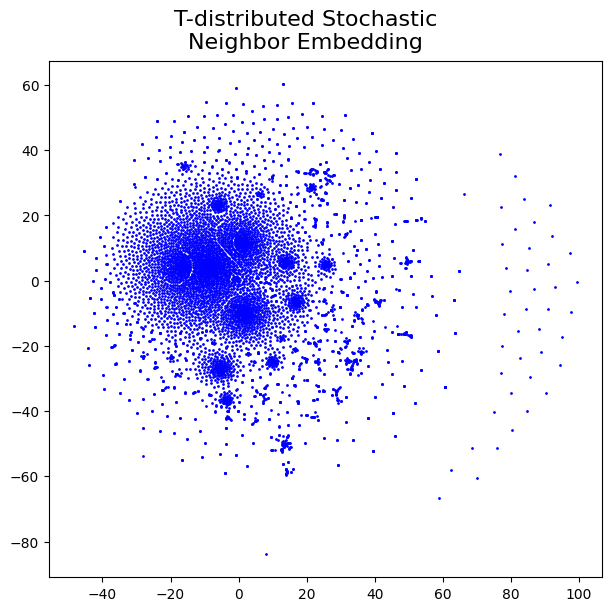

In [60]:
fig, ax = plt.subplots(figsize=(6, 6), facecolor="white", constrained_layout=True)
fig.suptitle("T-distributed Stochastic\nNeighbor Embedding", size=16)
plt.plot(X_embedded[:,0], X_embedded[:,1], 'b.', ms=2)

In [87]:
X=[]
g = generator()
for i,el in enumerate(g):
    if i>2000:
        break
    X.append(el)

X = np.array(X)
print(X.shape)

(2001, 15625)


In [110]:
X_embedded3 = TSNE(n_components=3, learning_rate='auto',init='random', perplexity=30, n_iter=1000, early_exaggeration=12).fit_transform(X)
X_embedded3.shape

(2001, 3)

MovieWriter imagemagick unavailable; using Pillow instead.


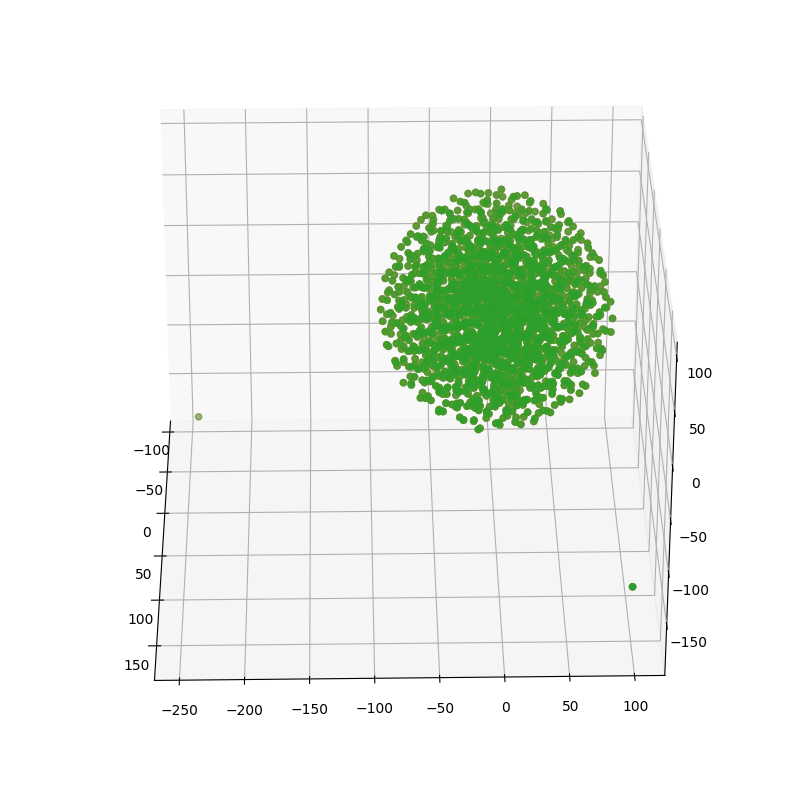

In [113]:
from mpl_toolkits.mplot3d import Axes3D  
from matplotlib import cm
from matplotlib import animation

XVal=X_embedded3[:,0]
YVal=X_embedded3[:,1]
ZVal=X_embedded3[:,2]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
def init():
    ax.scatter(XVal, YVal, ZVal)
    return fig


def animate(i):
    # azimuth angle : 0 deg to 360 deg
    ax.view_init(elev=30, azim=i)
    return fig,


fig = init()


# Animate
ani = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=360, interval=10)

fn = './3dAnim'
# ani.save(fn+'.mp4',writer='ffmpeg',fps=1000/20)
ani.save(fn+'.gif',writer='imagemagick',fps=1000/20)